In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

import zipfile, os, shutil

dataset = '/content/gdrive/My Drive/AI/AI 팀플/clothes.zip'
dst_path = '/content/clothes_data'
dst_file = os.path.join(dst_path, 'clothes.zip')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
if not os.path.exists(dst_path):
  os.makedirs(dst_path)

# copy zip file
shutil.copy(dataset, dst_file) # copy to colab instance storage
  
with zipfile.ZipFile(dst_file, 'r') as file:
  file.extractall(dst_path)

In [3]:
import cv2 as cv
import re
import numpy as np
from matplotlib import pyplot as plt

In [4]:
X = []
Y = []

total_len = 0
input_shape = (96, 96, 3)

subdir = os.listdir(dst_path)
subdir.remove('clothes.zip')
for folder in subdir:
  for image in os.listdir(os.path.join(dst_path, folder)):
    path_to_image = os.path.join(dst_path, folder, image)
    image = cv.imread(path_to_image)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB) # OpenCV uses BGR....
    image = cv.resize(image, (input_shape[1], input_shape[0]))
    label = re.findall(r'\w+\_\w+', folder)[0].split('_') # [black, dress]
    total_len +=1

    X.append(image)
    Y.append(label)

# train_cats_dir = os.path.join(dst_path, 'subset/train/cats')
# train_dogs_dir = os.path.join(dst_path, 'subset/train/dogs')


# print('total training cat images:', len(os.listdir(train_cats_dir)))
# print('total training dog images:', len(os.listdir(train_dogs_dir)))

In [5]:
print(total_len)
print(len(X))
print(len(Y))

11385
11385
11385


['blue', 'dress']


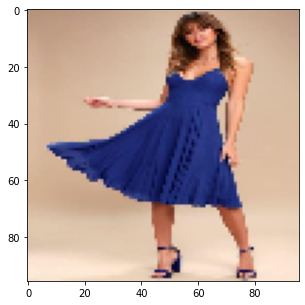

In [6]:
# for check
print(Y[1000])
plt.figure(figsize=(5,5))
plt.imshow(X[1000])

In [7]:
from sklearn.preprocessing import MultiLabelBinarizer

In [8]:
# mlb = MultiLabelBinarizer()
# Y = mlb.fit_transform(Y)
# print(len(Y))

# print(mlb.classes_)
# print(Y[0]) # white shorts

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X = np.array(X, dtype='float64') / 255.0
Y = np.array(Y, dtype='object')

x, test_x, y, test_y = train_test_split(X, Y, test_size=0.1, stratify=Y, shuffle = True, random_state=1)
train_x, val_x, train_y, val_y = train_test_split(x, y, test_size=0.2, stratify=y, shuffle=True, random_state=1)

print(x.shape, test_x.shape, y.shape, test_y.shape)
print(train_x.shape, val_x.shape, train_y.shape, val_y.shape)

(10246, 96, 96, 3) (1139, 96, 96, 3) (10246, 2) (1139, 2)
(8196, 96, 96, 3) (2050, 96, 96, 3) (8196, 2) (2050, 2)


In [11]:
color_unique = np.unique(Y[:,0])
type_unique = np.unique(Y[:,1])

In [12]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from keras.layers import BatchNormalization, Activation, Dropout
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

In [13]:
# augmentation
datagen = ImageDataGenerator(rotation_range = 45,
                            width_shift_range = 0.1,
                            height_shift_range = 0.1,
                            zoom_range = 0.2,
                            horizontal_flip = True,
                            validation_split = 0.2)

In [14]:
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model

In [15]:
tr_color_groups = train_y[:,0]
tr_type_groups = train_y[:,1]

val_color_groups = val_y[:,0]
val_type_groups = val_y[:,1]

In [16]:
# x = layers.Conv1D(32, 3, input_shape=input_shape, activation='relu')(image_input) 
# x = layers.MaxPooling1D(5)(x) 
# x = layers.Conv1D(64, 5, activation='relu', padding='same')(x) 
# x = layers.Conv1D(64, 5, activation='relu')(x) 
# x = layers.MaxPooling1D(5)(x) 
# x = layers.Conv1D(128, 5, activation='relu')(x) 
# x = layers.Conv1D(128, 5, activation='relu')(x) 
# x = layers.GlobalMaxPooling1D()(x)
# x = layers.Dense(256, activation='relu')(x)

#                         ┌─> Dense -> age_prediction        => MSE
# posts_input -> ... -> X ├─> Dense -> income_prediction     => categorical_crossentropy loss
#                         └─> Dense -> gender_prediction     => binary_crossentropy loss

image_input = Input(shape=(input_shape), dtype='float64', name='image')
x = layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape)(image_input)
x = layers.MaxPooling2D(2,2)(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D(2,2)(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)

color_prediction = layers.Dense(len(color_unique), activation='softmax', name='color')(x)
type_prediction = layers.Dense(len(type_unique), activation='softmax', name='type')(x)

model = Model(image_input,
              [color_prediction, type_prediction])

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 94, 94, 32)   896         ['image[0][0]']                  
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 47, 47, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 45, 45, 64)   18496       ['max_pooling2d[0][0]']          
                                                                                              

In [18]:
from tensorflow.keras.optimizers import Nadam

In [19]:
model.compile(optimizer=Nadam(lr=0.001), 
              loss={
                  'color': 'categorical_crossentropy',
                  'type': 'categorical_crossentropy'
              },
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/nadam.py:78: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


In [20]:
model.fit(x=train_x, y={'color': tr_color_groups, 'type': tr_type_groups}, epochs=10, validation_data=(val_x, {'color': val_color_groups, 'type': val_type_groups})) # 일단 val 뺴봄

Epoch 1/10


ValueError: ignored